In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings(action='ignore')

#model building
#RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
df=pd.read_csv("CarPrice_Clean.csv")

In [3]:
df.head()

,Unnamed: 0,price,wheelbase,curbweight,enginesize,boreratio,horsepower,fueleconomy,carlength,carwidth,...,ohcv,rotor,five,four,six,three,twelve,two,Medium,Highend
0,0,13495,88.6,2548,130,3.47,111,23.70,168.8,64.1,...,0,0,0,1,0,0,0,0,1,0
1,1,16500,88.6,2548,130,3.47,111,23.70,168.8,64.1,...,0,0,0,1,0,0,0,0,1,0
2,2,16500,94.5,2823,152,2.68,154,22.15,171.2,65.5,...,1,0,0,0,1,0,0,0,1,0
3,3,13950,99.8,2337,109,3.19,102,26.70,176.6,66.2,...,0,0,0,1,0,0,0,0,1,0
4,4,17450,99.4,2824,136,3.19,115,19.80,176.6,66.4,...,0,0,1,0,0,0,0,0,1,0


In [4]:
df.drop("Unnamed: 0",axis=1, inplace=True)

In [5]:
np.random.seed(0)
train, test=train_test_split(df, train_size=0.75, test_size=0.25, random_state=42)

In [6]:
scaler = MinMaxScaler()
num_vars = ['wheelbase', 'curbweight', 'enginesize', 'boreratio', 'horsepower','fueleconomy','carlength','carwidth','price']
train[num_vars] = scaler.fit_transform(train[num_vars])

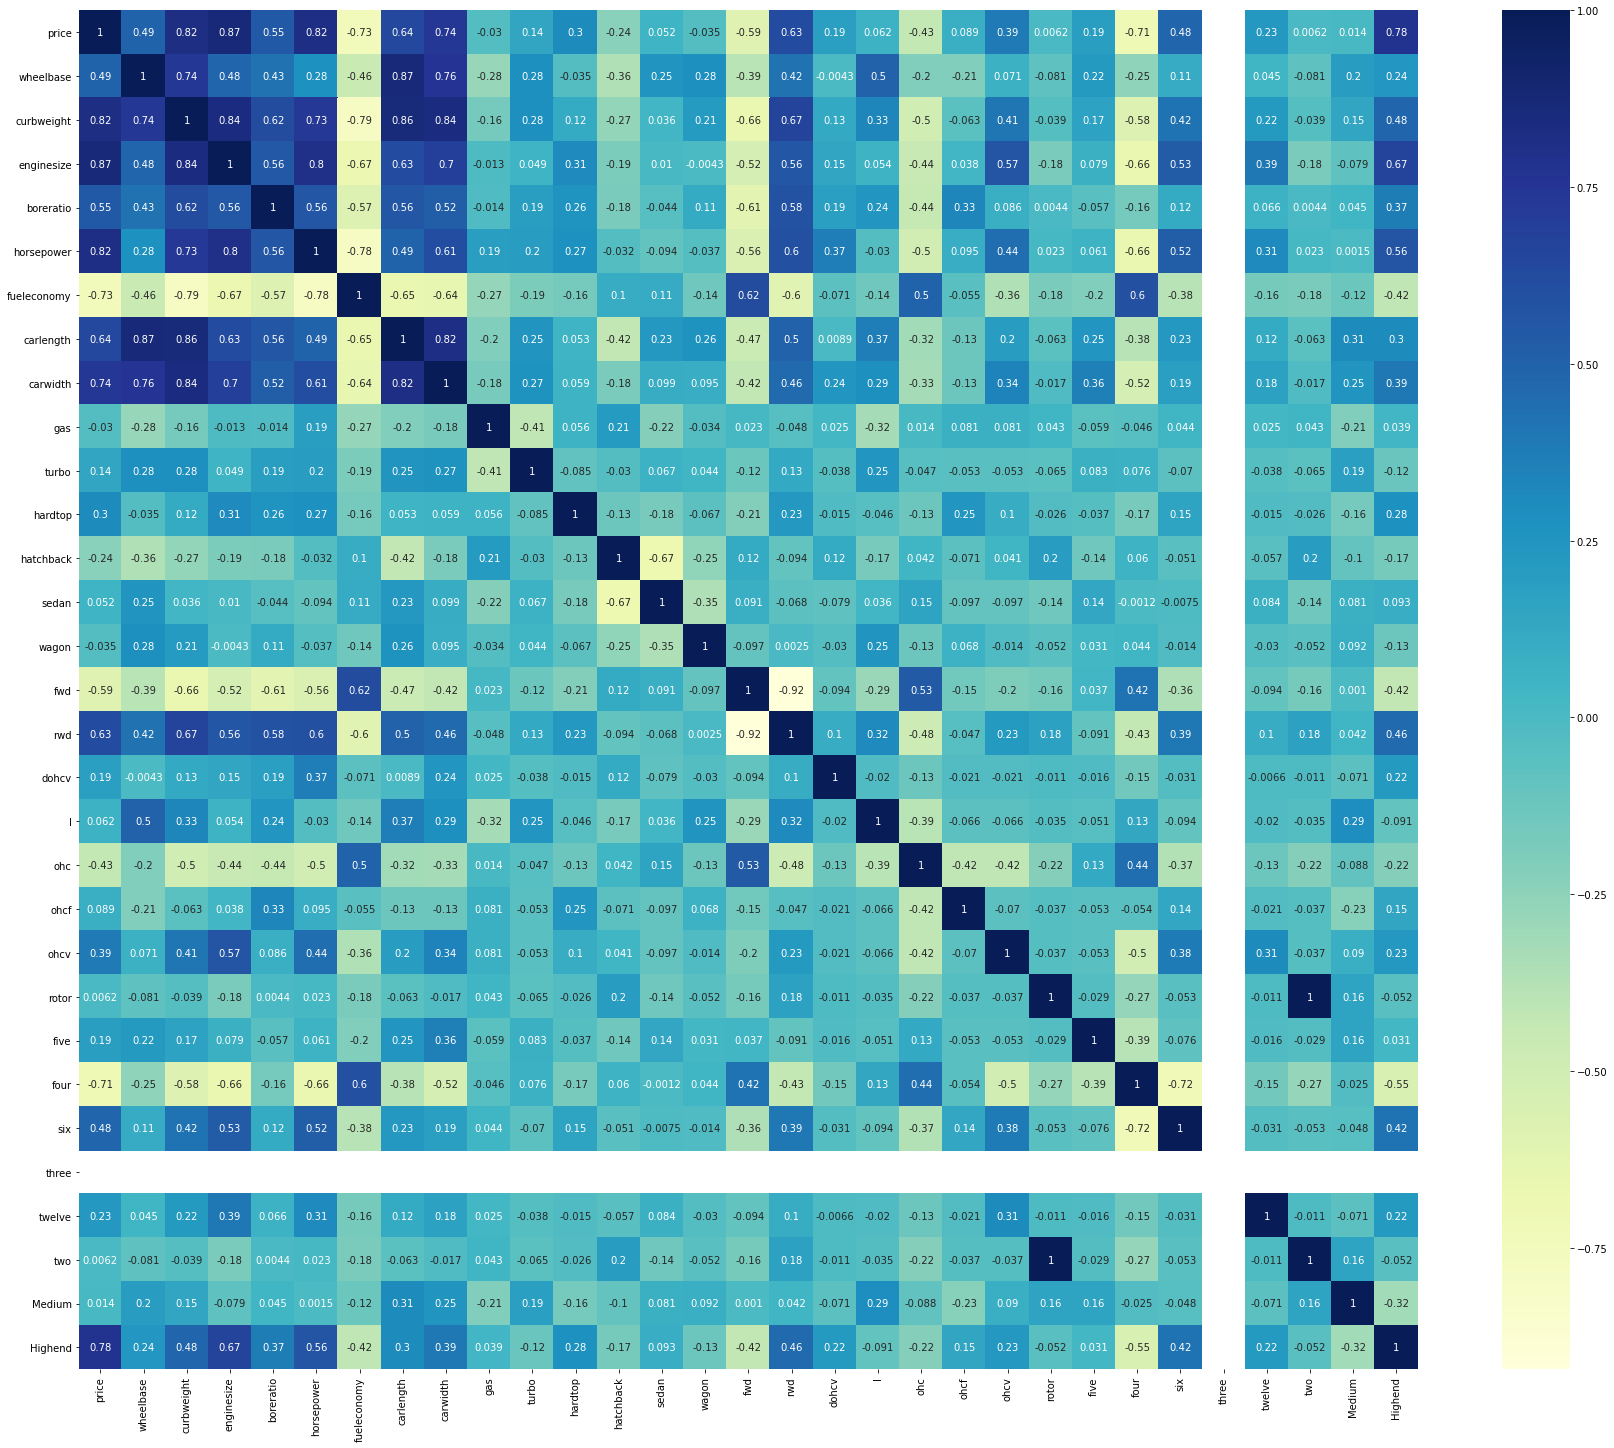

In [7]:
#Correlation using heatmap
plt.figure(figsize = (30, 25))
sns.heatmap(train.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [8]:
#Dividing data into X and y variables
y_train = train.pop('price')
X_train = train

---

## Model building using Linear Regression

In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train)
rfe=RFE(lr,10)
rfe = rfe.fit(X_train, y_train)

In [10]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('wheelbase', False, 14),
 ('curbweight', True, 1),
 ('enginesize', False, 10),
 ('boreratio', False, 7),
 ('horsepower', True, 1),
 ('fueleconomy', False, 2),
 ('carlength', False, 13),
 ('carwidth', True, 1),
 ('gas', False, 20),
 ('turbo', False, 19),
 ('hardtop', False, 12),
 ('hatchback', True, 1),
 ('sedan', True, 1),
 ('wagon', True, 1),
 ('fwd', False, 17),
 ('rwd', False, 16),
 ('dohcv', True, 1),
 ('l', False, 18),
 ('ohc', False, 15),
 ('ohcf', False, 8),
 ('ohcv', False, 6),
 ('rotor', False, 5),
 ('five', False, 4),
 ('four', True, 1),
 ('six', False, 3),
 ('three', False, 21),
 ('twelve', True, 1),
 ('two', False, 9),
 ('Medium', False, 11),
 ('Highend', True, 1)]

In [11]:
X_train.columns[rfe.support_]


Index(['curbweight', 'horsepower', 'carwidth', 'hatchback', 'sedan', 'wagon',
       'dohcv', 'four', 'twelve', 'Highend'],
      dtype='object')

In [12]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[X_train.columns[rfe.support_]]

In [13]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [14]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [15]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     236.2
Date:                Sat, 05 Nov 2022   Prob (F-statistic):           3.10e-83
Time:                        17:01:55   Log-Likelihood:                 252.11
No. Observations:                 153   AIC:                            -482.2
Df Residuals:                     142   BIC:                            -448.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0920      0.026      3.540      0.0

In [16]:
lm.pvalues<0.05

const          True
curbweight     True
horsepower     True
carwidth       True
hatchback      True
sedan          True
wagon          True
dohcv          True
four           True
twelve        False
Highend        True
dtype: bool

- pvalue greter thaht 5%, dropping column and buliding new model

In [17]:
def build_model(X,y):
    X = sm.add_constant(X) #Adding the constant
    lm = sm.OLS(y,X).fit() # fitting the model
    print(lm.summary()) # model summary
    print("\n")
    print(lm.pvalues <0.05)
    return X


In [18]:
    
def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [19]:
X_train_new = X_train_rfe.drop(["twelve"], axis = 1)

In [20]:
X_train_new = build_model(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     260.0
Date:                Sat, 05 Nov 2022   Prob (F-statistic):           5.58e-84
Time:                        17:01:55   Log-Likelihood:                 250.93
No. Observations:                 153   AIC:                            -481.9
Df Residuals:                     143   BIC:                            -451.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1014      0.025      4.007      0.0

In [21]:
#Calculating the Variance Inflation Factor
checkVIF(X_train_new)

,Features,VIF
0,const,41.58
1,curbweight,6.39
5,sedan,4.78
4,hatchback,4.50
3,carwidth,3.96
2,horsepower,3.83
6,wagon,2.96
8,four,2.04
9,Highend,1.79
7,dohcv,1.39


In [22]:
X_train_new = X_train_new.drop(["curbweight"], axis = 1)

In [23]:
X_train_new = build_model(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     267.3
Date:                Sat, 05 Nov 2022   Prob (F-statistic):           2.21e-82
Time:                        17:01:55   Log-Likelihood:                 243.95
No. Observations:                 153   AIC:                            -469.9
Df Residuals:                     144   BIC:                            -442.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0951      0.026      3.611      0.0

In [24]:
checkVIF(X_train_new)

,Features,VIF
0,const,41.39
4,sedan,4.78
3,hatchback,4.44
1,horsepower,2.82
5,wagon,2.81
7,four,2.04
2,carwidth,1.87
8,Highend,1.76
6,dohcv,1.23


---

In [25]:
lm = sm.OLS(y_train,X_train_new).fit()
y_train_price = lm.predict(X_train_new)

Text(0.5, 0, 'Errors')

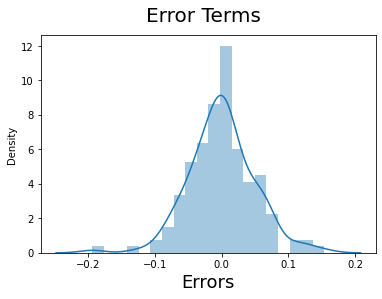

In [26]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)  

In [27]:
#Scaling the test set
num_vars = ['wheelbase', 'curbweight', 'enginesize', 'boreratio', 'horsepower','fueleconomy','carlength','carwidth','price']
test[num_vars] = scaler.fit_transform(test[num_vars])

In [28]:
#Dividing into X and y
y_test = test.pop('price')
X_test = test

In [29]:
# Now let's use our model to make predictions.
X_train_new = X_train_new.drop('const',axis=1)
# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [30]:
# Making predictions
y_pred = lm.predict(X_test_new)

In [31]:
from sklearn.metrics import r2_score 
r2_score(y_test, y_pred)

0.7651575738458077

Text(0, 0.5, 'y_pred')

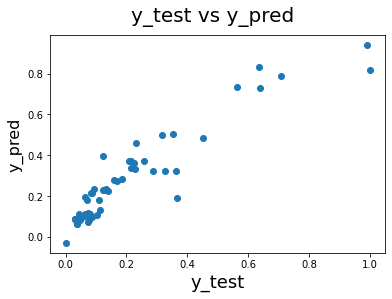

In [32]:
#EVALUATION OF THE MODEL
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16) 

In [33]:
X_test.head()

,wheelbase,curbweight,enginesize,boreratio,horsepower,fueleconomy,carlength,carwidth,gas,turbo,...,ohcv,rotor,five,four,six,three,twelve,two,Medium,Highend
15,0.492711,0.722222,0.599190,0.797753,0.985294,0.104539,0.714925,0.578947,1,0,...,0,0,0,0,1,0,0,0,0,1
9,0.376093,0.648839,0.283401,0.247191,0.823529,0.104539,0.553731,0.666667,1,1,...,0,0,1,0,0,0,0,0,1,0
100,0.309038,0.337479,0.238866,0.471910,0.360294,0.419532,0.482090,0.429825,1,0,...,0,0,0,1,0,0,0,0,1,0
132,0.364431,0.485075,0.242915,0.707865,0.455882,0.254470,0.679104,0.543860,1,0,...,0,0,0,1,0,0,0,0,1,0
68,0.682216,0.937811,0.493927,0.752809,0.551471,0.232462,0.743284,0.877193,0,1,...,0,0,1,0,0,0,0,0,0,1


---

### Pickling the model file for Deployment

In [37]:
import pickle

In [38]:
pickle.dump(lm,open("regmodel.pkl",'wb'))

In [39]:
pickled_model=pickle.load(open("regmodel.pkl","rb"))

In [45]:
pickled_model.predict(X_test_new[0:1].values)

array([0.78782088])